In [4]:
# 导入依赖
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision.models import resnet18

import matplotlib.pyplot as plt
import numpy as np

In [5]:
class DepthwiseSeparableConv(nn.Module):
    """
    深度可分离卷积模块

    将标准卷积分解为深度卷积和点卷积两步：
    1. 深度卷积：对每个输入通道独立进行空间卷积
    2. 逐点卷积：使用1x1卷积进行跨通道信息融合
    """

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False):
        super(DepthwiseSeparableConv, self).__init__()

        # 深度卷积
        self.depthwise = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels, bias=bias),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True)
        )

        # 逐点卷积
        self.pointwise = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

In [6]:
class MobileNetBlock(nn.Module):
    """
    MobileNet基本块

    包含一个深度卷积和可选的残差连接

    """

    def __init__(self, in_channels, out_channels, stride=1):
        super(MobileNetBlock,self).__init__()

        self.stride = stride
        self.use_residual = (stride == 1 and in_channels == out_channels)

        # 深度可分离卷积
        self.conv = DepthwiseSeparableConv(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=stride,
            padding=1
        )

    def forward(self, x):
        out = self.conv(x)

        if self.use_residual:
            out = out + x

        return out



In [7]:
class MobileNet(nn.Module):
    """
    MobileNet 完整网络实现
    网络结构：
    1. 标准卷积层
    2. 多个深度可分离卷积块
    3. 全局平局池化
    4. 全连接分类器

    参数：
        num_classes：分类器的类别数
        width_multiplier：宽度乘子
        input_size：输入图像尺寸
        dropout_rate：dropout概率
    """

    def __init__(self, num_classes=1000, width_multiplier=1.0, input_size=224, dropout_rate=0.2):
        super(MobileNet, self).__init__()

        self.num_classes = num_classes
        self.width_multiplier = width_multiplier
        self.input_size = input_size

        self.cfg = [
            [64, 1], 
            [128, 2], # 下采样
            [128, 1],
            [256, 2], # 下采样
            [256, 1],
            [512, 2], # 下采样
            [512, 1], # 重复5此512通道的块
            [512, 1],
            [512, 1],
            [512, 1],
            [512, 1],
            [1024, 2], # 下采样
            [1024, 1]
        ]

        self.cfg = [[int(channels * width_multiplier), stride] for channels, stride in self.cfg]

        # 第一层：标准卷积
        first_channel = int(32 * width_multiplier)

        self.first_conv = nn.Sequential(
            nn.Conv2d(3, first_channel, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(first_channel),
            nn.ReLU(inplace=True)
        )

        # 可分离卷积层序列
        layers = []
        in_channels = first_channel

        for out_channels, stride in self.cfg:
            layers.append(MobileNetBlock(in_channels, out_channels, stride))
            in_channels = out_channels

        self.features = nn.Sequential(*layers)

        self.last_channel = int(1024 * width_multiplier)

        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.last_channel, num_classes)
        )
        self._initialize_weights()

    def _initialize_weights(self):
        """
        权重初始化
        """

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        batch_size = x.size(0)

        x = self.first_conv(x)
        x = self.features(x)
        x = F.adaptive_avg_pool2d(x, (1, 1)) # 全局平均池化（替代全连接层，减少参数）
        x = x.view(batch_size, -1) # 展平特征
        x = self.classifier(x)

        return x
    
    def get_model_info(self):
        """
        获取模型信息
        """

        total_params = sum(p.numel() for p in self.parameters())
        trainabel_params = sum(p.numel() for p in self.parameters() if p.requires_grad)

        return{
            'total_parameters': total_params,
            'trainable_parameters': trainabel_params,
            'model_size_mb': total_params * 4 / (1024 * 1024),
            'width_multiplier': self.width_multiplier,
            'num_classes': self.num_classes,
            'input_size': self.input_size
        }


In [8]:
# 定义数据预处理流程
transform = transforms.Compose([
    # 随机水平翻转 (数据增强)
    transforms.RandomHorizontalFlip(),
    # 将PIL图像或numpy数组转换为torch张量
    # 并自动将像素值从[0,255]归一化到[0,1]
    transforms.ToTensor()
])

# 加载CIFAR-10训练集
dataset = torchvision.datasets.CIFAR10(
    root='../../../Data',  # 数据集存储路径
    train=True,            # 加载训练集
    download=True,         # 如果数据集不存在则自动下载
    transform=transform    # 应用定义的数据预处理
)

# 划分训练集和验证集 (80%训练, 20%验证)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

# 加载CIFAR-10测试集
test_set = torchvision.datasets.CIFAR10(
    root='../../../Data',
    train=False,           # 加载测试集
    download=True,
    transform=transform    # 应用相同的预处理
)

# 创建数据加载器
train_loader = DataLoader(
    train_set,
    batch_size=64,   # 每个batch包含64张图像
    shuffle=True     # 每个epoch打乱数据顺序
)

val_loader = DataLoader(
    val_set,
    batch_size=64,   # 验证集batch大小
    shuffle=False    # 验证集不需要打乱
)

test_loader = DataLoader(
    test_set,
    batch_size=100,  # 测试集batch大小
    shuffle=False    # 测试集不需要打乱
)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet18(num_classes=10).to(device)
mobilenet = MobileNet(num_classes=10).to(device)
mobilenet_0_5 = MobileNet(num_classes=10, width_multiplier=0.5).to(device)
mobilenet_0_75 = MobileNet(num_classes=10, width_multiplier=0.75).to(device)

In [10]:
mobilenet

MobileNet(
  (first_conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (features): Sequential(
    (0): MobileNetBlock(
      (conv): DepthwiseSeparableConv(
        (depthwise): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (pointwise): Sequential(
          (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
    )
    (1): MobileNetBlock(
      (conv): DepthwiseSeparableConv(
        (depthwise): Sequential(
          (0): Conv2d(64, 64, 

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer_resnet = torch.optim.SGD(resnet.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
optimizer_mobilenet = torch.optim.SGD(mobilenet.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
optimizer_mobilenet_0_5 = torch.optim.SGD(mobilenet_0_5.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
optimizer_mobilenet_0_75 = torch.optim.SGD(mobilenet_0_75.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

scheduler_resnet = torch.optim.lr_scheduler.StepLR(optimizer_resnet, step_size=10, gamma=0.1)
scheduler_mobilenet = torch.optim.lr_scheduler.StepLR(optimizer_mobilenet, step_size=10, gamma=0.1)
scheduler_mobilenet_0_5 = torch.optim.lr_scheduler.StepLR(optimizer_mobilenet_0_5, step_size=10, gamma=0.1)
scheduler_mobilenet_0_75 = torch.optim.lr_scheduler.StepLR(optimizer_mobilenet_0_75, step_size=10, gamma=0.1)


In [12]:
def train_epoch(model, loader, optimizer):
    model.train()

    total_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in loader:
        # 将数据移动到指定设备(CPU/GPU)
        inputs, targets = inputs.to(device), targets.to(device)
        
        # 清零优化器的梯度 (避免梯度累积)
        optimizer.zero_grad()
        
        # 前向传播: 计算模型输出
        outputs = model(inputs)
        
        # 计算损失
        loss = criterion(outputs, targets)
        
        # 反向传播: 计算梯度
        loss.backward()
        
        # 优化器更新模型参数
        optimizer.step()
        
        # 统计信息更新
        total_loss += loss.item()  # 累加损失值
        
        # 计算预测结果 (取最大概率的类别)
        _, preds = outputs.max(1)
        
        # 统计正确预测数
        correct += preds.eq(targets).sum().item()
        
        # 统计总样本数
        total += targets.size(0)

    avg_loss = total_loss / len(loader)
    accuracy = 100. * correct / total

    return avg_loss, accuracy


In [13]:
def eval_epoch(model, loader):
    """
    执行模型评估(验证/测试)
    
    参数:
        model: 要评估的模型
        loader: 评估数据加载器(验证集或测试集)
    
    返回:
        avg_loss: 平均损失
        accuracy: 准确率(%)
    """
    # 将模型设置为评估模式 (禁用dropout/batchnorm的特定行为)
    model.eval()
    
    # 初始化统计变量
    total_loss = 0.0
    correct = 0
    total = 0
    
    # 禁用梯度计算 (节省内存和计算资源)
    with torch.no_grad():
        # 遍历所有batch
        for inputs, targets in loader:
            # 数据移动到设备
            inputs, targets = inputs.to(device), targets.to(device)
            
            # 前向传播
            outputs = model(inputs)
            
            # 计算损失
            loss = criterion(outputs, targets)
            
            # 统计信息更新
            total_loss += loss.item()
            
            # 计算预测结果
            _, preds = outputs.max(1)
            
            # 统计正确预测数
            correct += preds.eq(targets).sum().item()
            
            # 统计总样本数
            total += targets.size(0)
    
    # 计算平均指标
    avg_loss = total_loss / len(loader)
    accuracy = 100. * correct / total
    
    return avg_loss, accuracy

In [14]:
epochs = 50
history = {"resnet_train": [], "resnet_val": [], "mobilenet_train": [], "mobilenet_val": [], "mobilenet_0.5_train": [], "mobilenet_0.5_val": [], "mobilenet_0.75_train": [], "mobilenet_0.75_val": []}


for epoch in range(1, epochs+1):
    r_train_loss, r_train_acc = train_epoch(resnet, train_loader, optimizer_resnet)
    r_val_loss, r_val_acc = eval_epoch(resnet, val_loader)

    d_train_loss, d_train_acc = train_epoch(mobilenet, train_loader, optimizer_mobilenet)
    d_val_loss, d_val_acc = eval_epoch(mobilenet, val_loader)

    m_5_train_loss, m_5_train_acc = train_epoch(mobilenet_0_5, train_loader, optimizer_mobilenet_0_5)
    m_5_val_loss, m_5_val_acc = eval_epoch(mobilenet_0_5, val_loader)

    m_75_train_loss, m_75_train_acc = train_epoch(mobilenet_0_75, train_loader, optimizer_mobilenet_0_75)
    m_75_val_loss, m_75_val_acc = eval_epoch(mobilenet_0_75, val_loader)

    scheduler_resnet.step()
    scheduler_mobilenet.step()

    print(f"Epoch {epoch}")
    print(f" ResNet Train: loss={r_train_loss:.3f} acc={r_train_acc:.2f}% | Val: loss={r_val_loss:.3f} acc={r_val_acc:.2f}%")
    print(f" mobilenet Train: loss={d_train_loss:.3f} acc={d_train_acc:.2f}% | Val: loss={d_val_loss:.3f} acc={d_val_acc:.2f}%")
    print(f" mobilenet_0_5 Train: loss={m_5_train_loss:.3f} acc={m_5_train_acc:.2f}% | Val: loss={m_5_val_loss:.3f} acc={m_5_val_acc:.2f}%")
    print(f" mobilenet_0_75 Train: loss={m_75_train_loss:.3f} acc={m_75_train_acc:.2f}% | Val: loss={m_75_val_loss:.3f} acc={m_75_val_acc:.2f}%")

    history["resnet_train"].append(r_train_acc)
    history["resnet_val"].append(r_val_acc)
    history["mobilenet_train"].append(d_train_acc)
    history["mobilenet_val"].append(d_val_acc)
    history["mobilenet_0.5_train"].append(m_5_train_acc)
    history["mobilenet_0.5_val"].append(m_5_val_acc)
    history["mobilenet_0.75_train"].append(m_75_train_acc)
    history["mobilenet_0.75_val"].append(m_75_val_acc)

ModuleNotFoundError: No module named 'pydev_jupyter_utils'

In [37]:
torch.save(resnet.state_dict(), "resnet_cifar10.pth")
torch.save(mobilenet.state_dict(), "mobilenet_cifar10.pth")
torch.save(mobilenet_0_5.state_dict(), "mobilenet_0_5_cifar10.pth")
torch.save(mobilenet_0_75.state_dict(), "mobilenet_0_75_cifar10.pth")

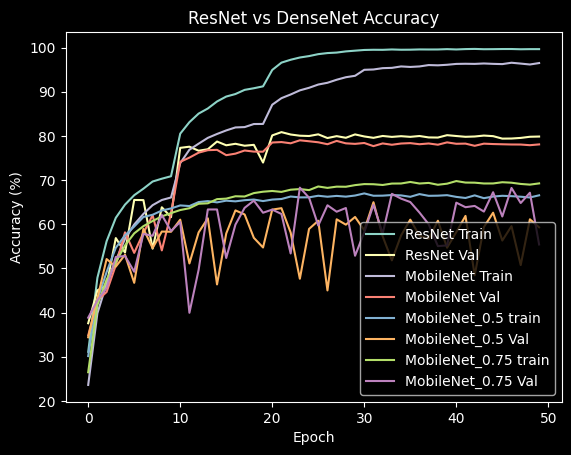

In [41]:
plt.plot(history["resnet_train"], label="ResNet Train")
plt.plot(history["resnet_val"], label="ResNet Val")
plt.plot(history["mobilenet_train"], label="MobileNet Train")
plt.plot(history["mobilenet_val"], label="MobileNet Val")
plt.plot(history["mobilenet_0.5_train"], label="MobileNet_0.5 train")
plt.plot(history["mobilenet_0.5_val"], label="MobileNet_0.5 Val")
plt.plot(history["mobilenet_0.75_train"], label="MobileNet_0.75 train")
plt.plot(history["mobilenet_0.75_val"], label="MobileNet_0.75 Val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("ResNet vs DenseNet Accuracy")
plt.show()